This notebook closely follows the guide here: https://betterprogramming.pub/creating-topographic-maps-in-python-convergence-of-art-and-data-science-7492b8c9fa6e

In [2]:
"""
Package install
"""

%pip install rasterio
%pip install matplotlib
%pip install tifffile
%pip install shapely
%pip install earthpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import rasterio
import tifffile as tiff

In [3]:
"""
Set path to TIF file of relevant geo, obtained from https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/elevation/copernicus-dem/elevation
I only need one tile, since Scotland is covered (except Shetland) by a single tile.
"""
file_path = os.path.join("TIF_SOURCE_FILE_PATH")

with rasterio.open(file_path) as src:
    dem1 = src.read(1, masked=True)
    transform1 = src.transform
    crs1 = src.crs

In [4]:
from rasterio.merge import merge

"""
Since we have only one tile here, I don't need to merge tiles, but might need it for other mapping.
"""

mosaic, out_trans = merge([rasterio.open(file_path)])

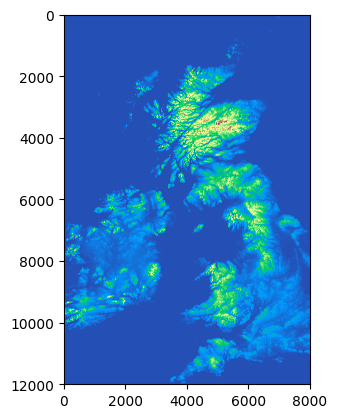

<Axes: >

In [5]:
from rasterio.plot import show

show(mosaic, cmap = 'terrain')

In [6]:
image_array = mosaic
tiff.imwrite('OUTPUT_FILE_PATH', image_array)

/Users/finlay/.pyenv/versions/3.11.7/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


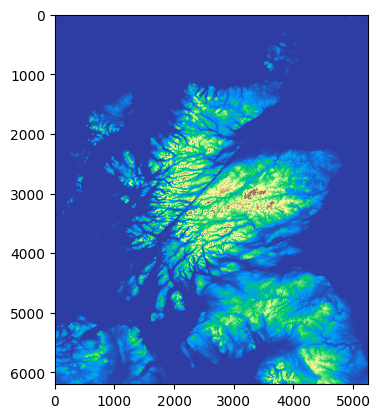

<Axes: >

In [7]:
from shapely.geometry import box
from rasterio.mask import mask

"""
Cut image down to relevant area and save a new file.
"""

bbox = box(1750, 500, 7000, 6700) #xmin, ymin, xmax, ymax

with rasterio.open('OUTPUT_FILE_PATH') as src:
    out_image, out_transform = mask(src, [bbox], crop=True)
    out_meta = src.meta.copy()

show(out_image, cmap='terrain')

cropped_tiff = out_image

tiff.imsave('CROPPED_FILE_PATH', cropped_tiff)

In [9]:
print('Min = ' + str(cropped_tiff.min()) + '     Max = ' + str(cropped_tiff.max()))

Min = -21.971317     Max = 1341.294


In [10]:
"""
Everything else is going to be done on the cropped file.
"""

file3 = rasterio.open('CROPPED_FILE_PATH')
dataset3 = file3.read()

/Users/finlay/.pyenv/versions/3.11.7/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


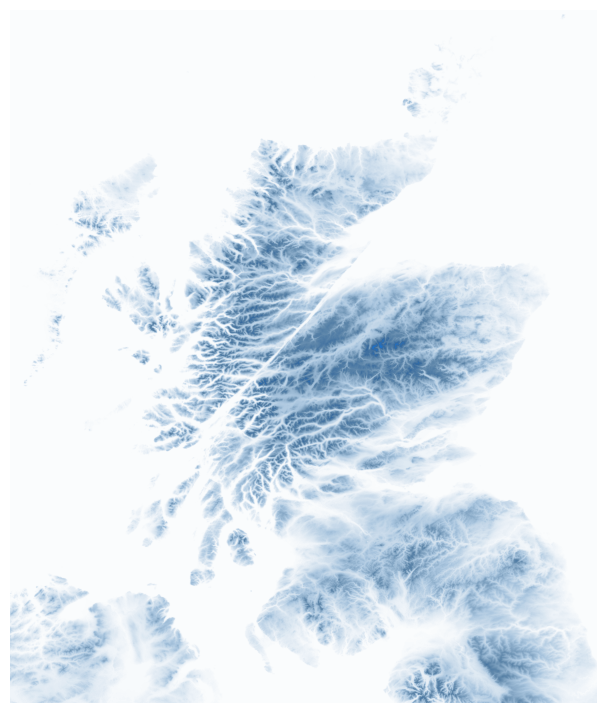

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

"""
Going to specify the color grading spectrum to use, as well as the density of the color spectrum.
"""

norm = colors.Normalize(vmin=-3, vmax=1341)

# Higher value here will increase the shading density
value_range = 240

scotland_colormap = LinearSegmentedColormap.from_list('scotland', ['#ffffff','#AAC6DF', '#6088AB', '#386A9D', '#0F74DF'], N=value_range)

fig = plt.figure(facecolor='#ffffff')
fig.set_size_inches(9, 9)
ax = plt.axes()
plt.imshow(dataset3[0], cmap=scotland_colormap)
ax.axis('off')
plt.show()

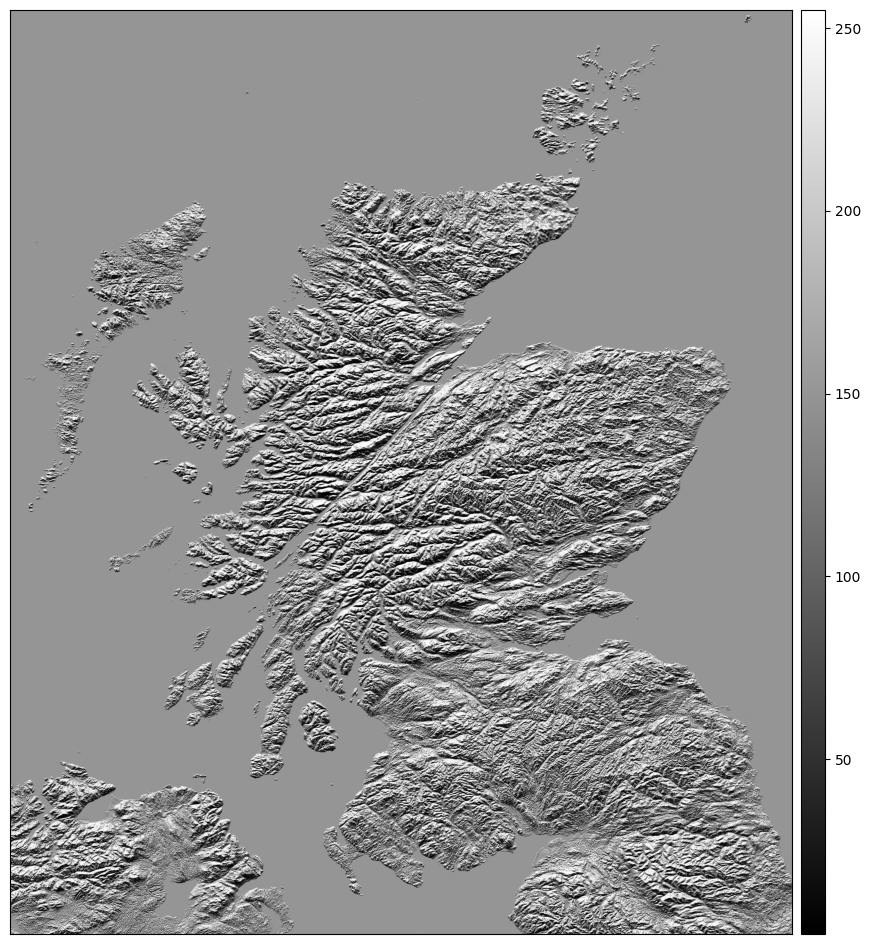

In [31]:
import earthpy.spatial as es
import earthpy.plot as ep

"""
Build mapping image with hill shading. Azimuth and altitude dictate the source of the light. 
Played with this to get desired definition on north-east coastline.
"""

hillshade = es.hillshade(dataset3[0], azimuth=350, altitude=10)

ep.plot_bands(hillshade, cmap='gray')
plt.show()

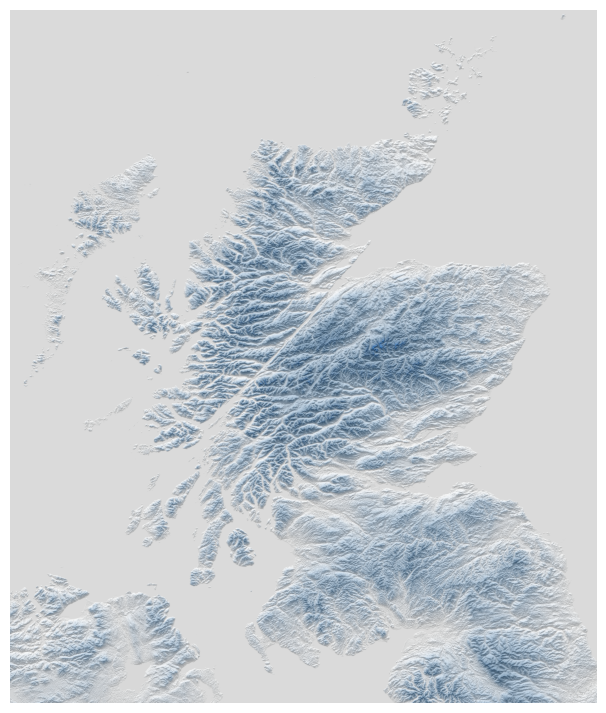

In [33]:
"""
Combining the hillshade with the color grading topography map. Played a little with the alpha, and thought 0.35 is about right.
Saving image to be photoshopped to remove the sea.
Original TIF file doesn't know what is water and what is land. So it colors the sea the grey of the low elevation areas.
Will eyedrop and replace that color in Photoshop.
"""

fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
bgcolor = "#ffffff"
i = plt.imshow(dataset3[0], cmap=scotland_colormap, norm=norm)
ax.imshow(hillshade, cmap="grey", alpha=0.35)
ax.axis('off')
plt.savefig('FINAL_FILE_PATH', dpi = 500, transparent = True)